# CS146 Project 1 - Linear Regression

## Data Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import random
import arviz as az
import aesara.tensor as at
import scipy.stats as sts

In [2]:
df_precipitation = pd.read_csv('historico_precipitaciones.csv')
df_temperature = pd.read_csv('historico_temperaturas.csv')
df = df_precipitation.merge(df_temperature)
df.head()

,año,mes,mm,días,máxima,mínima,media
0,1991,Enero,190.0,7,28.4,19.8,24.10
1,1991,Febrero,30.5,6,27.8,17.8,22.80
2,1991,Marzo,55.0,8,27.6,18.4,23.00
3,1991,Abril,125.6,12,22.4,13.6,18.00
4,1991,Mayo,68.4,7,20.7,12.2,16.45


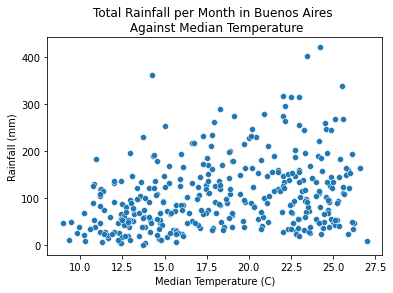

In [3]:
rainfall = df['mm']
med_temp = df['media']

sns.scatterplot(x=med_temp, y=rainfall)
plt.title('Total Rainfall per Month in Buenos Aires \n Against Median Temperature')
plt.ylabel('Rainfall (mm)')
plt.xlabel('Median Temperature (C)')
plt.show()

I found 2 datasets for Buenos Aires, one that tracked the rainfall over time and another the temperature over time. I have merged these datasets (since the data was for the same months and years), and taken the rainfall per month over the median temperature for that month as my data.

## Normal Linear Regression

### Visualising Priors

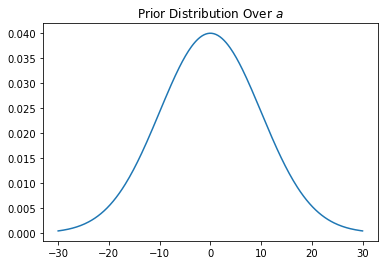

In [4]:
# prior over a, the intercept
mu = 0
sigma = 10

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 300)
y = sts.norm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.title('Prior Distribution Over $a$')
plt.show()

Using a normal distribution for the prior over a, the intercept, allows us to encompass the information that we know about the data. Ideally, we would want the model to have a positive intercept (using a half or log normal), since negative rainfall is not possible. However, this runs into some modelling issues, and so I have chosen to use a normal distribution instead.

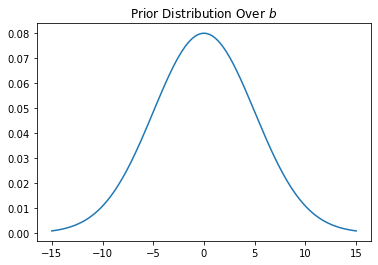

In [5]:
# prior over b, the slope(s)
mu = 0
sigma = 5

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 300)
y = sts.norm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.title('Prior Distribution Over $b$')
plt.show()

Since the value(s) of b determine(s) the slope(s) of the model, we should ensure the prior encompasses both negative and positive values. A sigma value of 5 puts most of the probability distribution between -15 and 15, which seems reasonable. This should avoid the possibility of producing wild posterior curves with large coefficients/b values.

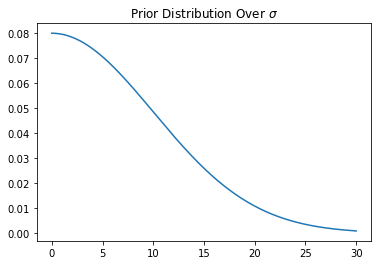

In [6]:
# prior over sigma, the standard deviation
mu = 0
sigma = 10

x = np.linspace(0, mu + 3*sigma, 300)
y = sts.halfnorm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.title('Prior Distribution Over $\sigma$')
plt.show()

We want a very wide prior over sigma, since we have no reason to prefer any value for the standard deviation in the data. We do, however, know that sigma must be positive. Using a half normal distribution allows us to restrict the prior distribution to positive values, and also puts some probability density on very large values such that these are possible for the posterior.

### Generating Samples from Posterior and Posterior Predictive

In [7]:
# code adapted from session 6.2 LPPD breakout workbook CS146
degrees = range(1, 4)
norm_inference = []

for degree in degrees:
    with pm.Model() as norm_model:

        # priors
        a = pm.Normal('a', mu = 0, sigma = 10)
        b = pm.Normal('b', mu = 0, sigma = 5, shape = degree)
        sigma = pm.HalfNormal('sigma', sigma = 10)
        
        # deterministic mu for each degree
        mu = a
        for i in range(0, degree):
            mu = mu + b[i] * df['media'] ** (i+1)
        mu = pm.Deterministic('mu', mu)

        # likelihood
        likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = df['mm'])
        
        # sampling
        inference = pm.sample(2000, tune = 2000, target_accept = 0.9)
        norm_post = pm.sample_posterior_predictive(inference, extend_inferencedata = True)
        norm_inference.append(norm_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 48 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 135 seconds.


### Checking Sampler

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,6.761,8.054,-8.490,21.868,0.145,0.107,3103.0,3257.0,1.0
b[0],5.314,0.446,4.507,6.186,0.008,0.006,3089.0,3429.0,1.0
sigma,66.913,2.223,62.807,71.136,0.033,0.024,4423.0,4316.0,1.0


array([<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.870,9.606,-18.573,17.281,0.172,0.121,3128.0,3499.0,1.0
b[0],7.273,1.396,4.680,9.925,0.027,0.019,2697.0,3252.0,1.0
b[1],-0.076,0.051,-0.175,0.016,0.001,0.001,3057.0,3729.0,1.0
sigma,66.770,2.220,62.513,70.907,0.035,0.024,4146.0,3741.0,1.0


array([<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-1.171,9.556,-19.478,16.067,0.148,0.119,4162.0,3826.0,1.0
b[0],-2.287,3.226,-8.413,3.696,0.071,0.050,2081.0,3134.0,1.0
b[1],0.997,0.329,0.400,1.628,0.007,0.005,2038.0,2818.0,1.0
b[2],-0.028,0.009,-0.044,-0.012,0.000,0.000,2090.0,3095.0,1.0
sigma,66.130,2.234,61.773,70.224,0.032,0.023,4862.0,3867.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'b\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:>]], dtype=object)

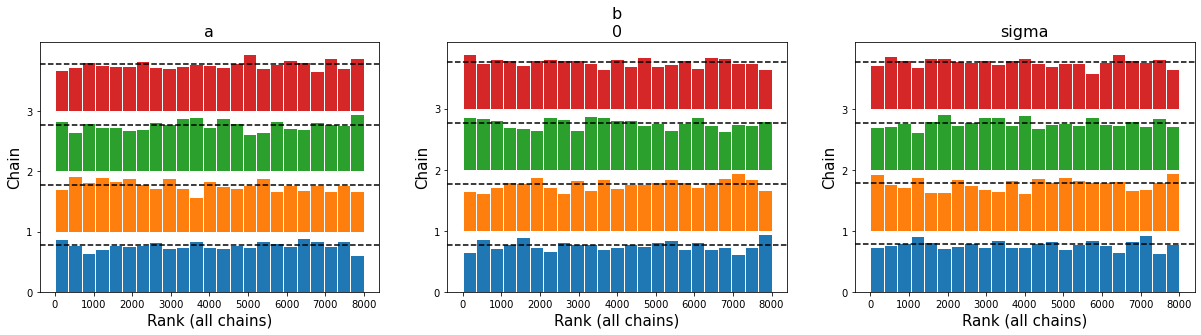

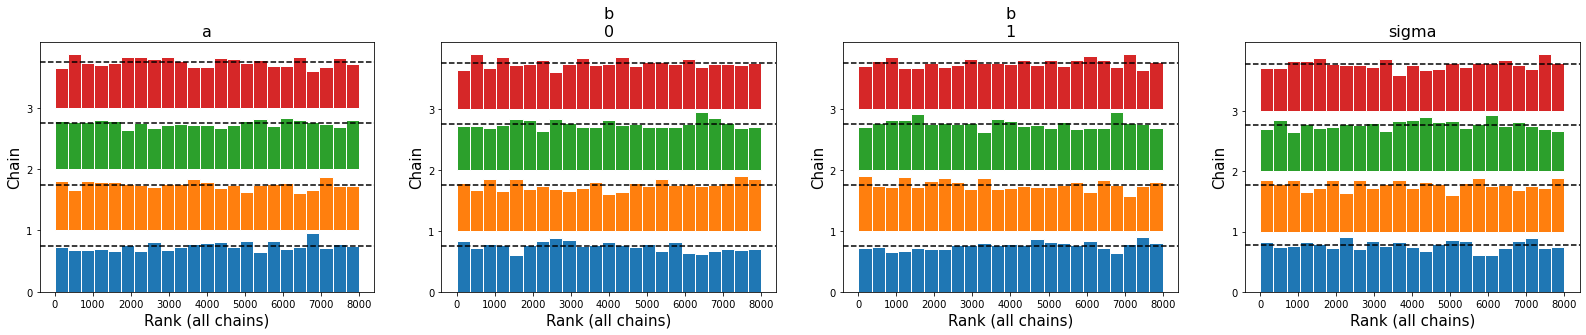

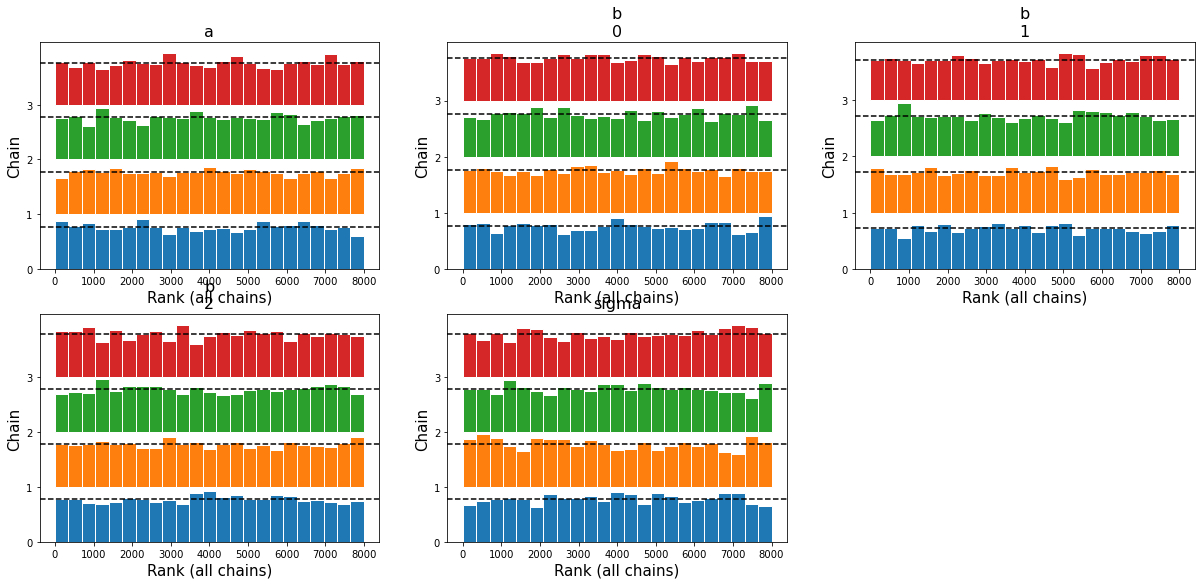

In [8]:
var_bar_mu = ['~mu']
for i in range(len(norm_inference)):
    display(az.summary(norm_inference[i], var_bar_mu))
    display(az.plot_rank(norm_inference[i], var_bar_mu))

Looking at the effective sample sizes for each of the linear, quadratic and cubic models, we see that they are all greater than 10% of the number of samples and all r_hats are 1.0 (so no red flags there). Furthermore, the rank plots are all roughly uniform, meaning each chain was randomly sampling from the posterior distribution and no specific chain got 'stuck' in any part of the distribution. All of this information indicates that our sampler is working correctly.

### Visualising and Interpreting the Posterior and Posterior Predictive

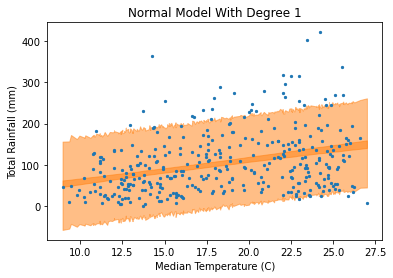

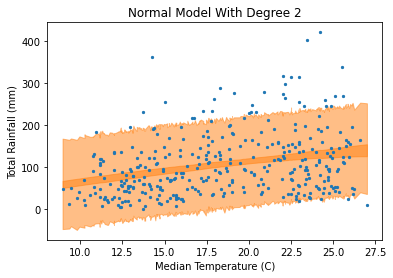

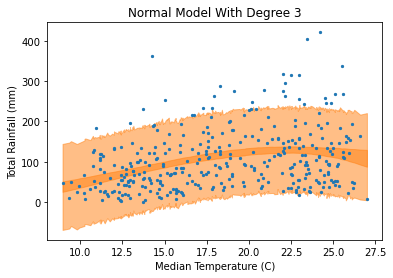

In [9]:
for i in range(len(norm_inference)):
    ax = az.plot_hdi(df['media'], norm_inference[i].posterior['mu'], smooth = False, hdi_prob = 0.89)
    az.plot_hdi(df['media'], norm_inference[i].posterior_predictive['likelihood'], ax = ax, smooth = False, hdi_prob = 0.89)
    plt.scatter(df['media'], df['mm'], s = 5)
    plt.title(f'Normal Model With Degree {i+1}')
    plt.xlabel('Median Temperature (C)')
    plt.ylabel('Total Rainfall (mm)')
    plt.show()

Plotting the posterior distributions for each normal model (linear, quadratic and cubic), we see that the fit is reasonable. The dark orange represents an 89% credible interval of mean rainfall, and the light orange an 89% credible interval of rainfall.

The 89% credible interval for the mean rainfall is fairly narrow for all posteriors, which makes sense since we have a lot of data points. The 89% credible interval for the rainfall is much wider since this should encompass about 89% of the data. We see that these intervals are homoscedastic, since we didn't model any variation in sigma in our model. However, there seems to be a wider spread of rainfall given median temperature when the temperature is greater. I have therefore decided to model the data using heteroscedastic models as well.

## Normal Linear Regression: Heteroscedastic

### Visualising Priors

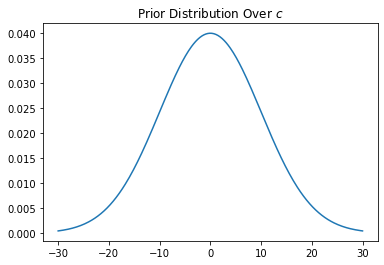

In [10]:
# prior over c, the intercept of the standard deviation
mu = 0
sigma = 10

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 300)
y = sts.norm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.title('Prior Distribution Over $c$')
plt.show()

The logic used for priors over a and b here is the same as the above model. Ideally, for the prior over the intercept of the stanard deviation, we would use a distribution such as the halfnormal where there are only positive values (since sigma must be positive). However, this ran into errors when modelling.

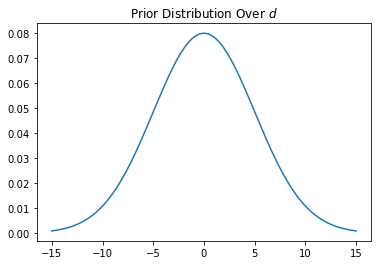

In [11]:
# prior over d, the slope(s) of the standard deviation
mu = 0
sigma = 5

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 300)
y = sts.norm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.title('Prior Distribution Over $d$')
plt.show()

For the prior over d, the slope(s) of the standard deviation, we can use a normal distribution to show that some standard deviation values can be greater than the 'intercept', and some less than the 'intercept'. 

### Generating Samples from Posterior and Posterior Predictive

In [12]:
# code adapted from session 6.2 LPPD breakout workbook CS146
degrees = range(1, 4)
norm_inference_hetero = []

for degree in degrees:
    with pm.Model() as norm_model_hetero:

        # priors
        a = pm.Normal('a', mu = 0, sigma = 10)
        b = pm.Normal('b', mu = 0, sigma = 5, shape = degree)
        c = pm.Normal('c', sigma = 10)
        d = pm.Normal('d', sigma = 5, shape = degree)
        
        # deterministic mu and sigma for each degree
        mu = a
        sigma = c
        
        for i in range(0, degree):
            mu = mu + b[i] * df['media'] ** (i+1)
            sigma = sigma + d[i] * df['media'] ** (i+1)
            
        mu = pm.Deterministic('mu', mu)
        sigma = pm.Deterministic('sigma', sigma)

        # likelihood
        likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = df['mm'])

        # sampling
        inference = pm.sample(2000, tune = 2000, target_accept = 0.9)
        norm_post = pm.sample_posterior_predictive(inference, extend_inferencedata = True)
        norm_inference_hetero.append(norm_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 244 seconds.


### Checking Sampler

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.143,7.678,-12.103,16.529,0.140,0.101,3027.0,3713.0,1.0
b[0],5.628,0.486,4.740,6.561,0.009,0.006,3101.0,3449.0,1.0
c,7.691,6.903,-4.963,20.794,0.126,0.089,3012.0,3193.0,1.0
d[0],3.411,0.432,2.612,4.219,0.008,0.006,2961.0,3080.0,1.0


array([<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'c'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'d\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-1.373,9.470,-18.926,16.491,0.167,0.119,3203.0,3596.0,1.0
b[0],6.562,1.377,3.939,9.054,0.027,0.019,2543.0,3198.0,1.0
b[1],-0.040,0.052,-0.134,0.058,0.001,0.001,2762.0,3624.0,1.0
c,0.439,9.598,-16.517,19.406,0.174,0.123,3053.0,4138.0,1.0
d[0],4.798,1.282,2.485,7.307,0.025,0.018,2547.0,3203.0,1.0
d[1],-0.052,0.044,-0.135,0.031,0.001,0.001,2682.0,3653.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'c'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.754,9.681,-19.121,16.805,0.137,0.121,4994.0,4146.0,1.0
b[0],-1.702,3.006,-7.324,3.953,0.055,0.039,2977.0,3276.0,1.0
b[1],0.925,0.315,0.348,1.522,0.006,0.004,3039.0,3558.0,1.0
b[2],-0.026,0.008,-0.043,-0.011,0.000,0.000,3188.0,3771.0,1.0
c,0.839,9.307,-16.198,18.227,0.137,0.111,4646.0,4627.0,1.0
d[0],2.330,2.723,-2.591,7.658,0.050,0.035,3002.0,3690.0,1.0
d[1],0.231,0.276,-0.274,0.766,0.005,0.004,2973.0,3704.0,1.0
d[2],-0.008,0.007,-0.021,0.006,0.000,0.000,3035.0,3654.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'c'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

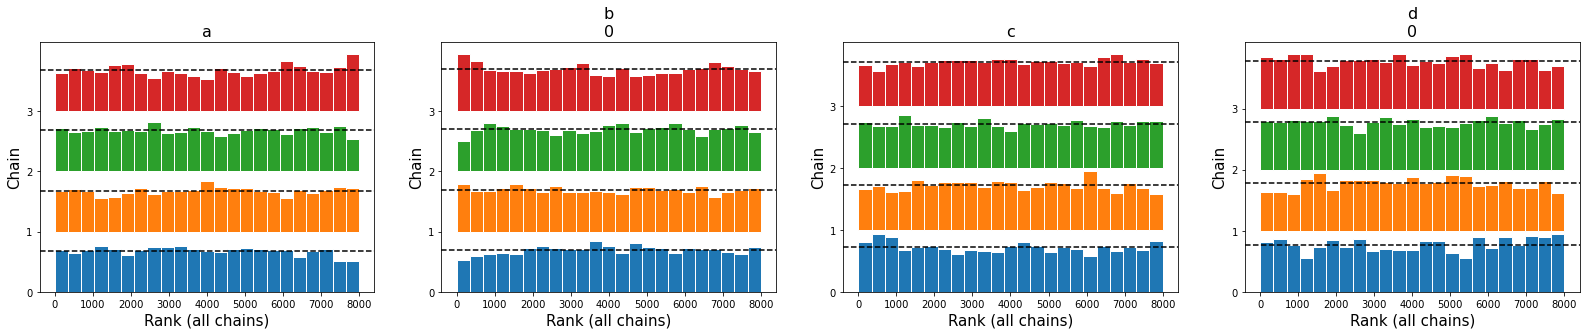

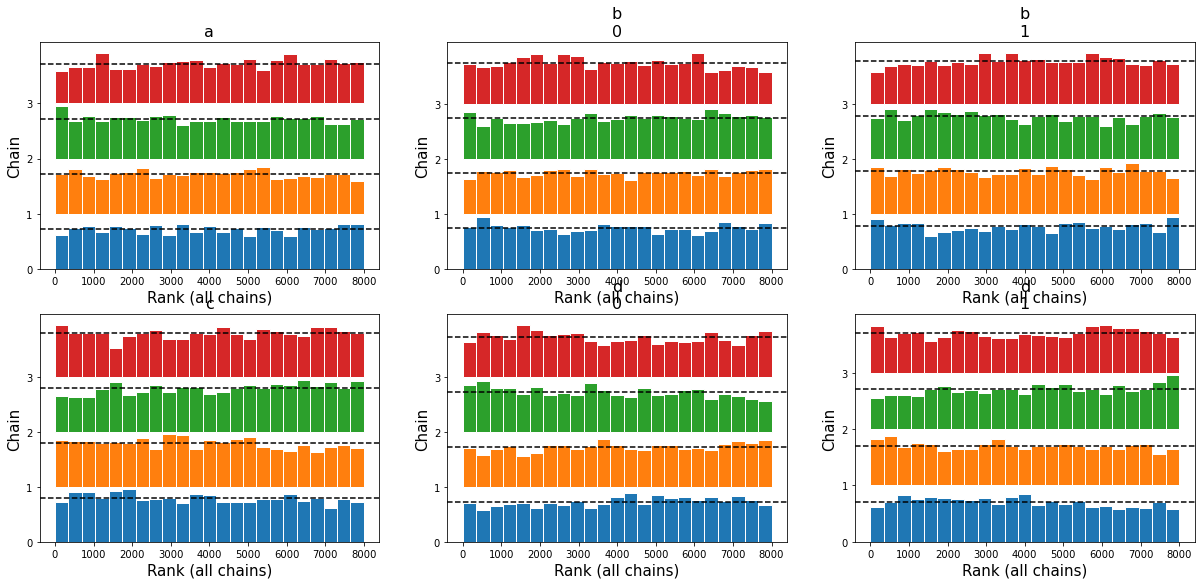

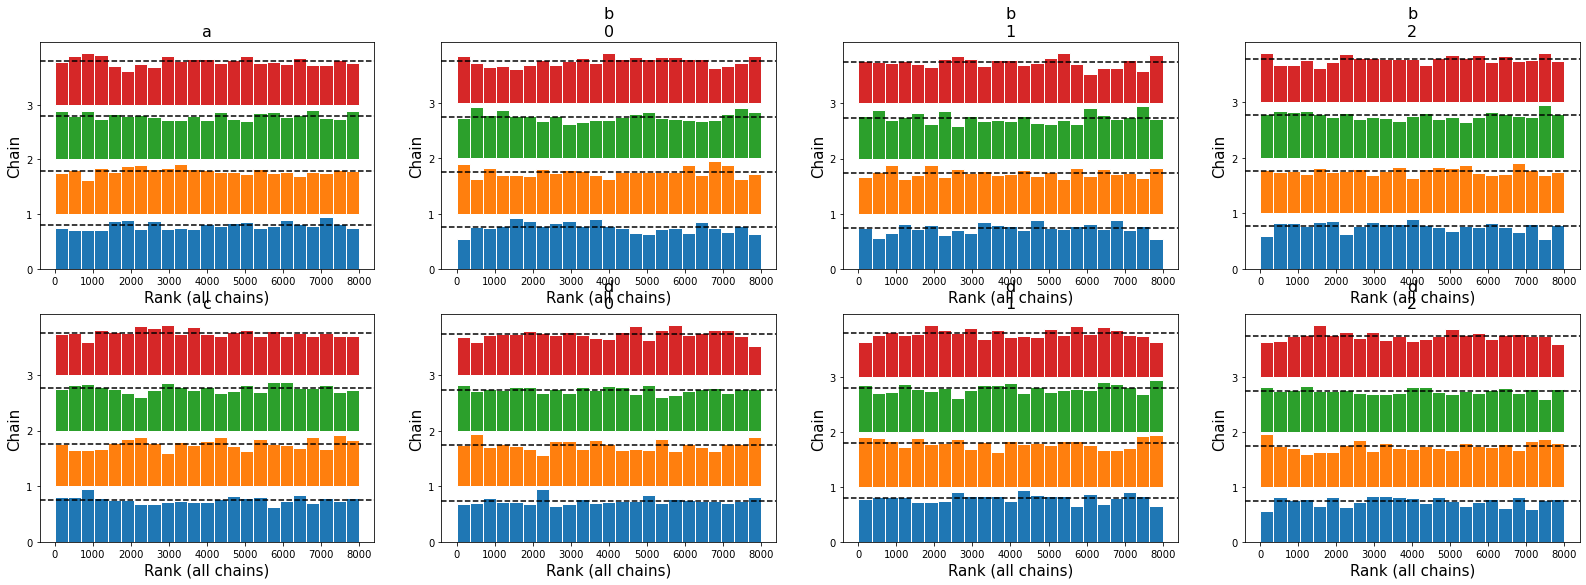

In [13]:
var_bar_mu_sigma = ['~mu', '~sigma']
for i in range(len(norm_inference_hetero)):
    display(az.summary(norm_inference_hetero[i], var_bar_mu_sigma))
    display(az.plot_rank(norm_inference_hetero[i], var_bar_mu_sigma))

We see that r_hat are all <= 1.01, effective sample sizes are greater than 10% of the number of samples and the rank plots are roughly uniform. This doesn't provide any evidence to show our sampler is not working correctly.

### Visualising and Interpreting the Posterior and Posterior Predictive

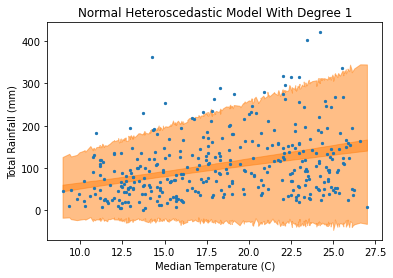

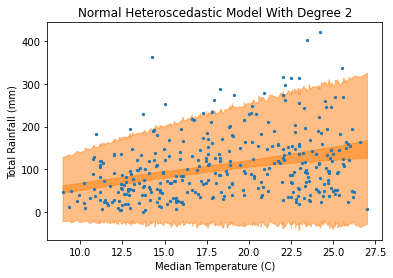

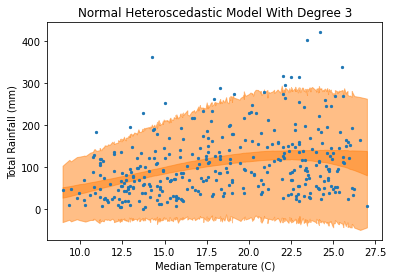

In [14]:
for i in range(len(norm_inference_hetero)):
    ax = az.plot_hdi(df['media'], norm_inference_hetero[i].posterior['mu'], smooth = False)
    az.plot_hdi(df['media'], norm_inference_hetero[i].posterior_predictive['likelihood'], ax = ax, smooth = False)
    plt.scatter(df['media'], df['mm'], s = 5)
    plt.title(f'Normal Heteroscedastic Model With Degree {i+1}')
    plt.xlabel('Median Temperature (C)')
    plt.ylabel('Total Rainfall (mm)')
    plt.show()

Different from the homoscedastic plots, we see that the variance across the range of median temperatures is much greater for larger values of temperature, as expected. The heteroscedastic model models this change in the data better.

## Student T Linear Regression

### Visualising Priors

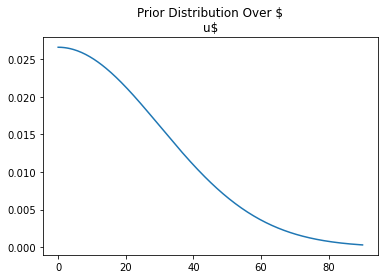

In [15]:
# prior over nu, a parameter of the student T distribution
mu = 0
sigma = 30

x = np.linspace(0, mu + 3*sigma, 300)
y = sts.halfnorm.pdf(x, mu, sigma)
plt.plot(x, y)
plt.title('Prior Distribution Over $nu$')
plt.show()

Again, the logic for a and b are the same as the above models. Because nu must be postive, we should restrict the prior to values greater than 0. The half normal can be used here. We set the standard deviation to about 30, ensuring most of the probability density lies between 0 and 30, since with a nu of 30, the T distribution resembles the normal.

### Generating Samples from Posterior and Posterior Predictive

In [16]:
# code adapted from session 6.2 LPPD breakout workbook CS146
t_inference = []

for degree in degrees:
    with pm.Model() as norm_model:

        # priors
        nu = pm.HalfNormal('nu', sigma = 30)
        a = pm.Normal('a', mu = 0, sigma = 10)
        b = pm.Normal('b', mu = 0, sigma = 5, shape = degree)
        sigma = pm.HalfNormal('sigma', sigma = 10)
        
        # deterministic mu for each degree 
        mu = a
        for i in range(0, degree):
            mu = mu + b[i] * df['media'] ** (i+1)
        mu = pm.Deterministic('mu', mu)

        # likelihood
        likelihood = pm.StudentT('likelihood', nu=nu, mu = mu, sigma = sigma, observed = df['mm'])

        # sampling
        inference = pm.sample(2000, tune = 2000, target_accept = 0.9)
        t_post = pm.sample_posterior_predictive(inference, extend_inferencedata = True)
        t_inference.append(t_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 65 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, a, b, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 202 seconds.


### Checking Sampler

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,7.186,7.819,-7.170,22.289,0.131,0.098,3545.0,4129.0,1.0
b[0],4.767,0.455,3.914,5.611,0.008,0.005,3491.0,3813.0,1.0
nu,4.703,1.457,2.618,7.211,0.024,0.018,4120.0,4113.0,1.0
sigma,52.278,3.362,45.980,58.530,0.052,0.037,4183.0,4282.0,1.0


array([<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-1.474,9.379,-19.021,16.011,0.156,0.114,3603.0,4287.0,1.0
b[0],6.740,1.339,4.278,9.242,0.024,0.017,3069.0,3674.0,1.0
b[1],-0.075,0.048,-0.164,0.016,0.001,0.001,3345.0,4043.0,1.0
nu,4.761,1.364,2.669,7.224,0.022,0.016,4112.0,4011.0,1.0
sigma,52.292,3.299,46.002,58.354,0.052,0.037,3989.0,4286.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:>]], dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.985,9.548,-18.763,16.609,0.130,0.110,5376.0,4995.0,1.0
b[0],-2.054,3.077,-7.824,3.707,0.059,0.042,2726.0,3852.0,1.0
b[1],0.920,0.317,0.331,1.513,0.006,0.004,2672.0,3709.0,1.0
b[2],-0.026,0.008,-0.042,-0.011,0.000,0.000,2730.0,3330.0,1.0
nu,5.063,1.565,2.694,7.753,0.028,0.020,3509.0,3452.0,1.0
sigma,52.468,3.205,46.128,58.068,0.054,0.038,3603.0,4309.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'b\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

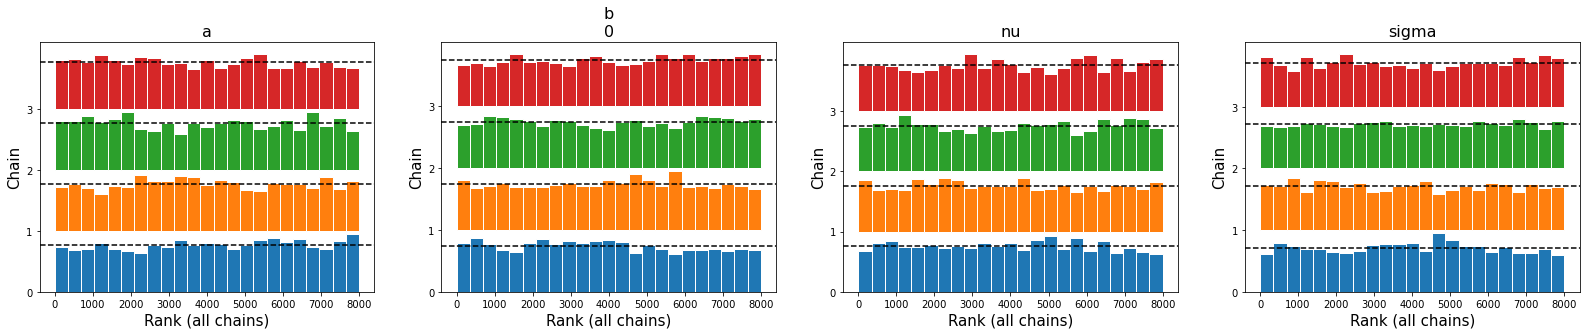

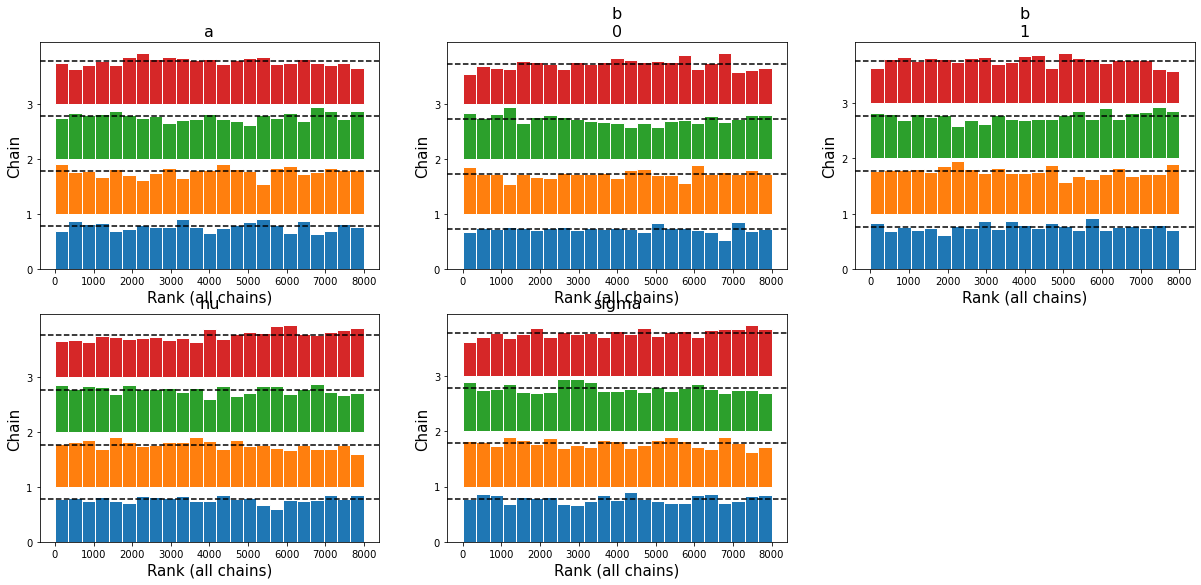

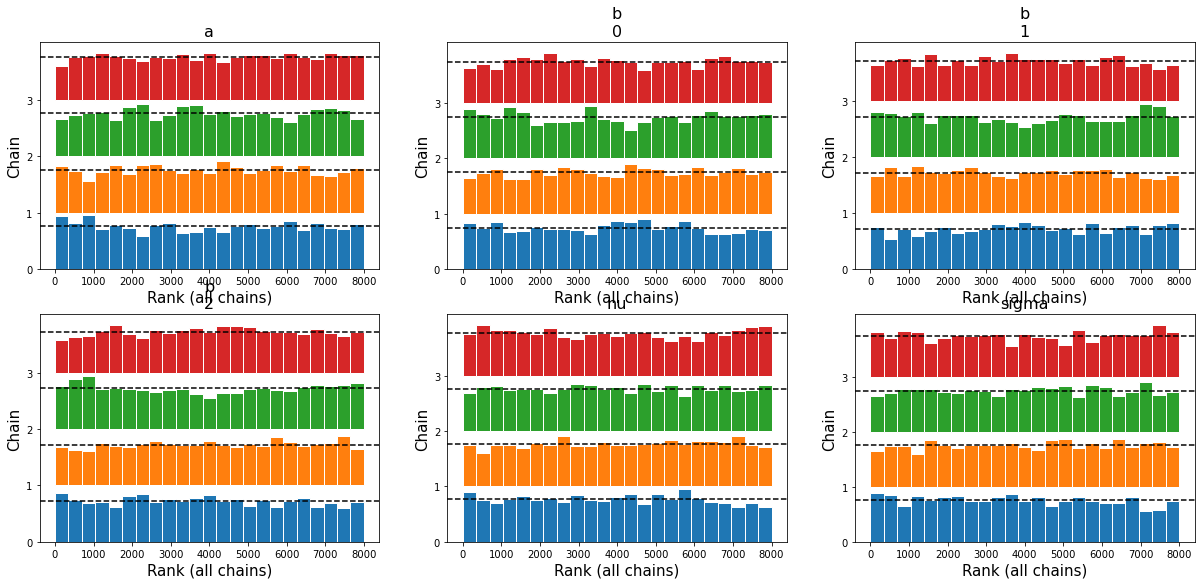

In [17]:
for i in range(len(t_inference)):
    display(az.summary(t_inference[i], var_bar_mu))
    display(az.plot_rank(t_inference[i], var_bar_mu))

We see that r_hat are all <= 1.01, effective sample sizes are greater than 10% of the number of samples and the rank plots are roughly uniform. This doesn't provide any evidence to show our sampler is not working correctly.

### Visualising and Interpreting the Posterior and Posterior Predictive

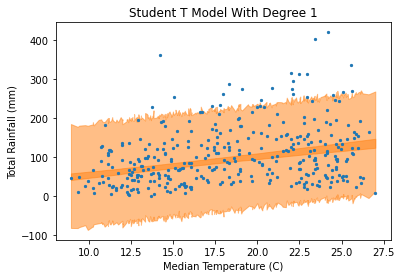

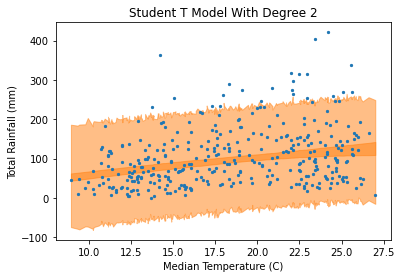

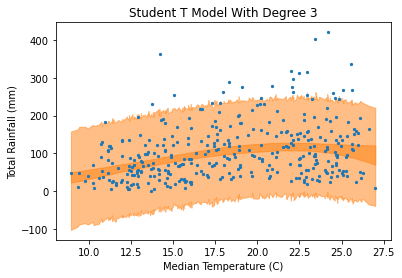

In [18]:
for i in range(len(t_inference)):
    ax = az.plot_hdi(df['media'], t_inference[i].posterior['mu'], smooth=False)
    az.plot_hdi(df['media'], t_inference[i].posterior_predictive['likelihood'], ax=ax, smooth=False)
    plt.scatter(df['media'], df['mm'], s = 5)
    plt.title(f'Student T Model With Degree {i+1}')
    plt.xlabel('Median Temperature (C)')
    plt.ylabel('Total Rainfall (mm)')
    plt.show()

The result from these models strongly resemble those from the normal homoscedastic models. The credible intervals for both the mean rainfall and the rainfall are almost identical, as we can see by comparing the intercept ranges. 

## Student T Linear Regression: Heteroscedastic

### Visualising Priors

All priors for this model are justified as above.

### Generating Samples from Posterior and Posterior Predictive

In [19]:
# code adapted from session 6.2 LPPD breakout workbook CS146
t_inference_hetero = []

for degree in degrees:
    with pm.Model() as norm_model:

        # priors
        nu = pm.HalfNormal('nu', sigma = 30)
        a = pm.Normal('a', mu = 0, sigma = 10)
        b = pm.Normal('b', mu = 0, sigma = 5, shape = degree)
        c = pm.Normal('c', mu = 0, sigma = 10)
        d = pm.Normal('d', mu = 0, sigma = 5, shape = degree)
        
        # deterministic mu and sigma for each degree
        mu = a
        sigma = c
        
        for i in range(0, degree):
            mu = mu + b[i] * df['media'] ** (i+1)
            sigma = sigma + d[i] * df['media'] ** (i+1)
            
        mu = pm.Deterministic('mu', mu)
        sigma = pm.Deterministic('sigma', sigma)

        # likelihood
        likelihood = pm.StudentT('likelihood', nu=nu, mu = mu, sigma = sigma, observed = df['mm'])

        # sampling
        inference = pm.sample(2000, tune = 2000, target_accept = 0.9)
        t_post = pm.sample_posterior_predictive(inference, extend_inferencedata = True)
        t_inference_hetero.append(t_post)
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, a, b, c, d]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, a, b, c, d]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 93 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, a, b, c, d]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 307 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


### Checking Sampler

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.469,7.968,-14.120,15.805,0.121,0.097,4340.0,4700.0,1.0
b[0],5.394,0.511,4.450,6.359,0.008,0.005,4414.0,4618.0,1.0
c,6.048,6.877,-6.989,18.825,0.108,0.079,4039.0,4515.0,1.0
d[0],3.091,0.450,2.222,3.894,0.007,0.005,3767.0,4293.0,1.0
nu,13.494,8.499,4.013,28.872,0.130,0.093,5592.0,4707.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'c'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'d\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:>]], dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-2.054,9.649,-19.737,16.303,0.159,0.112,3690.0,4595.0,1.0
b[0],6.298,1.397,3.760,8.994,0.026,0.018,2982.0,3930.0,1.0
b[1],-0.037,0.052,-0.135,0.061,0.001,0.001,3250.0,4409.0,1.0
c,0.424,9.536,-17.584,18.302,0.163,0.115,3425.0,4126.0,1.0
d[0],4.198,1.286,1.619,6.547,0.024,0.017,2899.0,3310.0,1.0
d[1],-0.042,0.044,-0.124,0.044,0.001,0.001,3151.0,4241.0,1.0
nu,13.993,9.335,3.696,30.513,0.155,0.109,4924.0,4381.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'c'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.721,9.714,-18.124,17.728,0.128,0.120,5740.0,5168.0,1.0
b[0],-1.964,3.013,-7.980,3.500,0.052,0.040,3381.0,3679.0,1.0
b[1],0.918,0.315,0.343,1.527,0.005,0.004,3372.0,3522.0,1.0
b[2],-0.026,0.008,-0.042,-0.011,0.000,0.000,3485.0,3871.0,1.0
c,1.065,9.601,-16.556,19.667,0.137,0.117,4951.0,4285.0,1.0
d[0],1.899,2.645,-2.916,6.955,0.050,0.035,2847.0,3920.0,1.0
d[1],0.221,0.263,-0.272,0.703,0.005,0.003,2905.0,4012.0,1.0
d[2],-0.007,0.007,-0.020,0.005,0.000,0.000,3031.0,3984.0,1.0
nu,13.865,9.384,3.901,30.162,0.169,0.133,5051.0,4263.0,1.0


array([[<AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'b\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'c'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'d\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'d\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

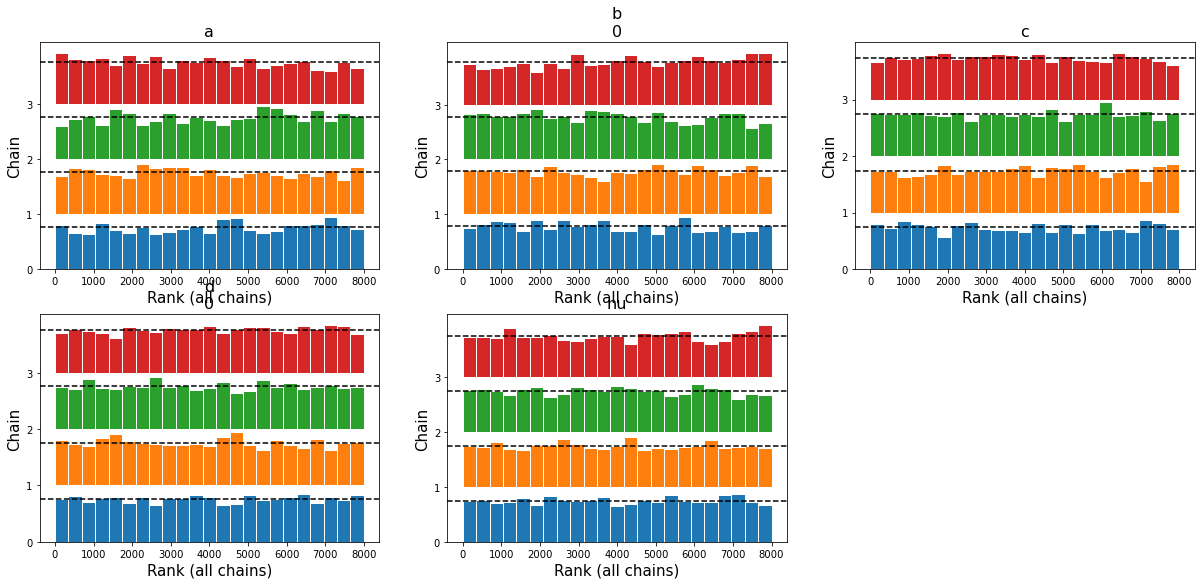

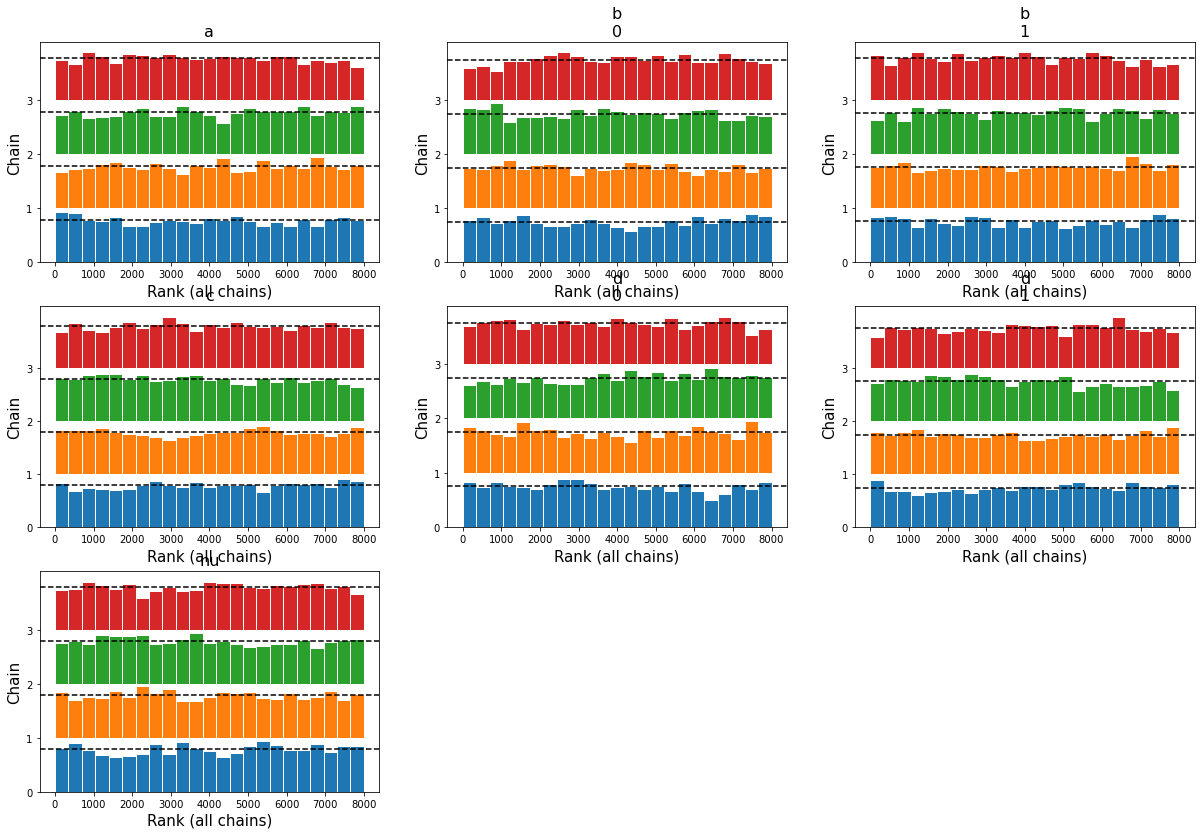

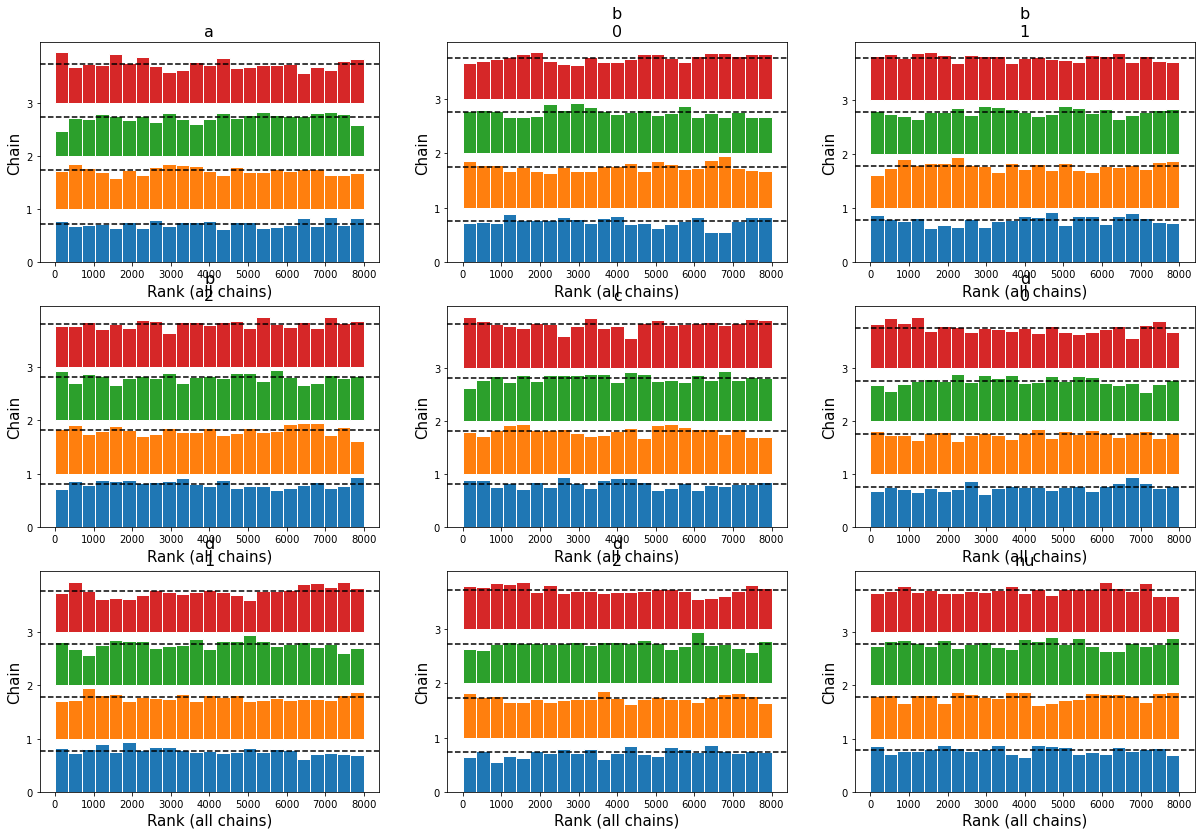

In [20]:
for i in range(len(t_inference_hetero)):
    display(az.summary(t_inference_hetero[i], var_bar_mu_sigma))
    display(az.plot_rank(t_inference_hetero[i], var_bar_mu_sigma))

We see that r_hat are all <= 1.01, effective sample sizes are greater than 10% of the number of samples and the rank plots are roughly uniform. This doesn't provide any evidence to show our sampler is not working correctly.

### Visualising and Interpreting the Posterior and Posterior Predictive

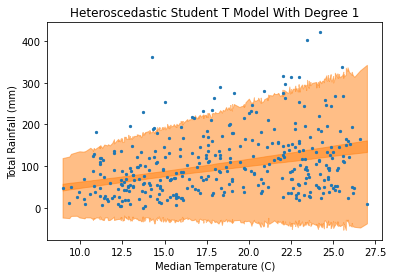

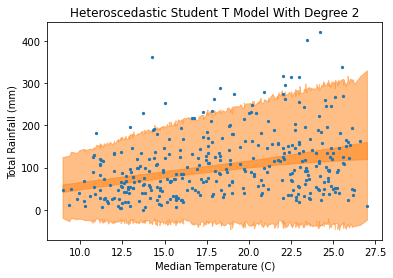

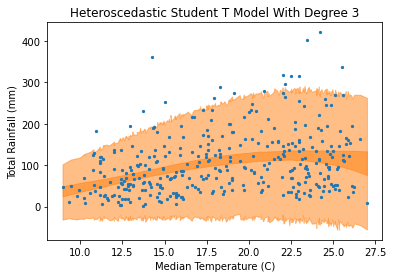

In [21]:
for i in range(len(t_inference_hetero)):
    ax = az.plot_hdi(df['media'], t_inference_hetero[i].posterior['mu'], smooth=False)
    az.plot_hdi(df['media'], t_inference_hetero[i].posterior_predictive['likelihood'], ax=ax, smooth=False)
    plt.scatter(df['media'], df['mm'], s = 5)
    plt.title(f'Heteroscedastic Student T Model With Degree {i+1}')
    plt.xlabel('Median Temperature (C)')
    plt.ylabel('Total Rainfall (mm)')
    plt.show()

Again, the posteriors and posterior predictives look extremely similar to the normal heteroscedastic models. We can see this by comparing the intercepts for the mean rainfall and rainfall credible intervals. In order to determine which model is a best fit to the data, and which model is the best for making predictions, we should conduct PSIS-LOO cross validation.

## Comparing Models Using PSIS-LOO CV

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
T Cubic Heteroscedastic,0,3986.155640,7.378791,0.000000,0.000000e+00,34.099763,0.000000,False,deviance
T Linear Heteroscedastic,1,3991.192264,4.875038,5.036625,2.539796e-01,34.195430,6.875072,False,deviance
T Quadratic Heteroscedastic,2,3992.008218,6.118302,5.852579,1.998907e-13,34.121707,5.955904,False,deviance
Normal Cubic Heteroscedastic,3,3995.207300,6.866771,9.051660,4.514792e-01,36.902065,8.396640,False,deviance
Normal Linear Heteroscedastic,4,3999.516969,3.822265,13.361330,4.060807e-02,37.209598,11.707131,False,deviance
Normal Quadratic Heteroscedastic,5,4000.312227,5.502087,14.156587,2.033059e-13,36.799920,10.313862,False,deviance
T Cubic,6,4004.150331,5.302117,17.994691,2.050594e-01,36.053008,11.407103,False,deviance
T Quadratic,7,4010.622459,4.331612,24.466820,4.887383e-02,36.330901,13.343939,False,deviance
T Linear,8,4012.113376,3.579364,25.957736,3.685682e-13,36.346743,13.443937,False,deviance
Normal Cubic,9,4019.554178,4.744683,33.398539,2.252921e-13,40.673318,15.086665,False,deviance


<AxesSubplot:xlabel='Deviance'>

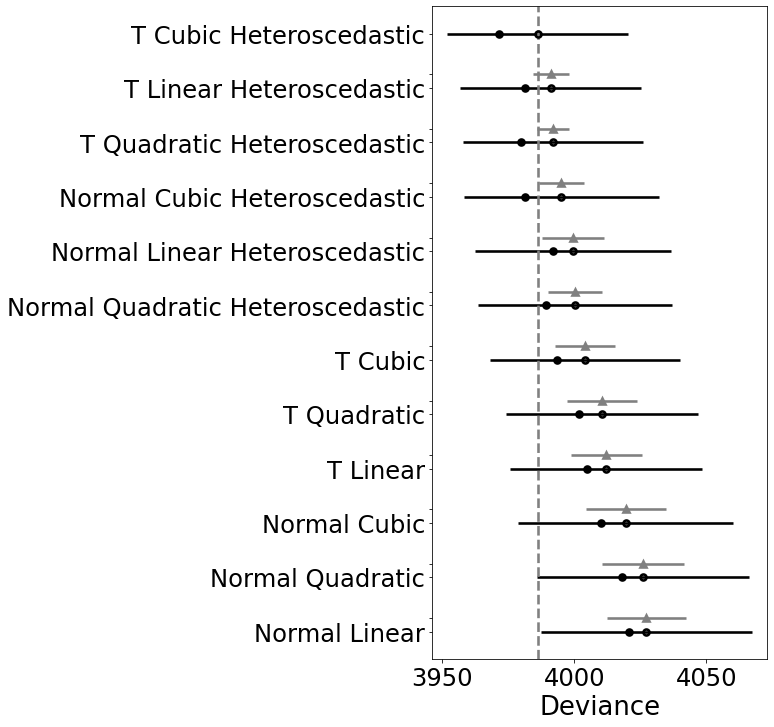

In [22]:
models = {'Normal Linear': norm_inference[0], 'Normal Quadratic': norm_inference[1], 
          'Normal Cubic': norm_inference[2], 'Normal Linear Heteroscedastic': norm_inference_hetero[0], 
          'Normal Quadratic Heteroscedastic': norm_inference_hetero[1], 
          'Normal Cubic Heteroscedastic': norm_inference_hetero[2],
          'T Linear': t_inference[0], 'T Quadratic': t_inference[1], 'T Cubic': t_inference[2],
          'T Linear Heteroscedastic': t_inference_hetero[0], 
          'T Quadratic Heteroscedastic': t_inference_hetero[1], 'T Cubic Heteroscedastic': t_inference_hetero[2]}
comparison = az.compare(models, ic='loo', scale='deviance')
display(comparison)
display(az.plot_compare(comparison))

PSIS-LOO cross-validation allows us to determine the out-of-sample deviance for each model. It achieves this by determining how much the posterior would change if we removed each individual observed datapoint, and summing these values. PSIS calculates this value by summing the log likelihoods of each data point given the posterior. To get the deviance, these values are multiplied by -2 such that lower values are indicative of better out-of-sample predictions.

We can see from the above plot that the T cubic heteroscedastic model has the best (lowest) deviance. However, there is overlap between the errors of the T linear heteroscedastic and T quadratic heteroscedastic models (the grey lines overlap with the dotted vertical marker). This means that we can't really say that the T cubic heteroscedastic model makes the best predictions. 

This indicates that the T distribution better models the outliers in the sample than the normal distribution, since the deviance for these models are lower. This makes sense, since the shape of the distribution has wider tails for low values of nu, and thus outlier are less improbable than for the normal distribution.

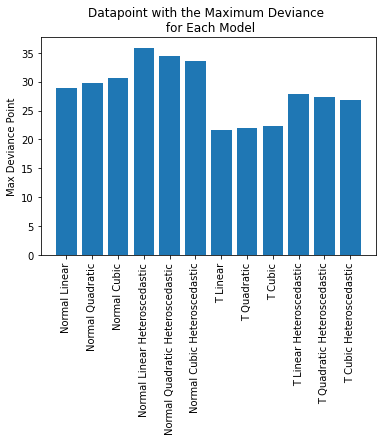

In [23]:
x = models.keys()
y = []
for model in x:
    y.append(max(az.loo(models[model], pointwise=True, scale='deviance').loo_i.values))
    
plt.bar(x, y)
plt.xticks(rotation = 'vertical')
plt.ylabel('Max Deviance Point')
plt.title('Datapoint with the Maximum Deviance \n for Each Model')
plt.show()

Plotting the maximum deviances (or 'information') within each model, we see that the T distributions have a lower greatest deviance than the normals, which makes sense given they account for outlier better. Though this analysis is not very robust since we cannot see the deviance for every datapoint and just the 'worst' outlier in each case (which might not even be the same point), it allows us to see that the T distribution better accounts for the outlier than the normal.

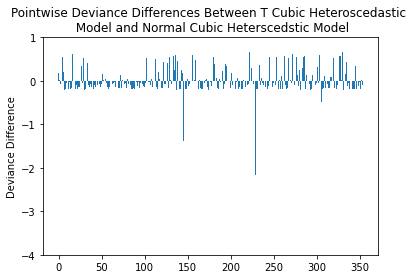

In [24]:
deviances = az.loo(models['T Cubic Heteroscedastic'], pointwise=True, scale='deviance').loo_i - az.loo(models['Normal Cubic Heteroscedastic'], pointwise=True, scale='deviance').loo_i
plt.bar(range(len(deviances)), deviances)
plt.ylim(-4, 1)
plt.ylabel('Deviance Difference')
plt.title('Pointwise Deviance Differences Between T Cubic Heteroscedastic \n Model and Normal Cubic Heterscedstic Model')
plt.show()

Picking 2 different models where the only difference is the t distribution versus normal distribution, we can plot the difference in deviance for each point. Here, negative values represent lower deviance for the T model, and positive values represent lower deviance for the normal model. We see that there are a couple of outliers in the model that are better accounted for by the t distribution. There are several positive values, meaning the normal model worked better for some points in the sample, however, there are considerably more negative values, where the T distribution modelled better (the posterior changed less when we remove these points).

## References

CS146. (2022). Log-pointwise-predictive-density (LPPD) Workbook. Structured learning exercise document. Retrieved October 21, 2022, from https://sle-collaboration.minervaproject.com/?id=e6da3604-eb97-4f86-a6da-b70cfb91b103&amp;userId=10803&amp;name=Catherine%2BJackson&amp;avatar=https%3A%2F%2Fs3.amazonaws.com%2Fpicasso.fixtures%2FCatherine_Jackson_10803_2022-04-05T15%3A13%3A26.803Z&amp;noPresence=1&amp;readOnly=1&amp;isInstructor=0&amp;signature=2f97efa81af38700afdfd17e343886de615ab8b7858fc806df334bc36a8ea66c 